In [9]:
# Step 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
from parse_data import load_json, parse_to_dataframe
from feature_engineering import aggregate_wallet_features
from model import train_model, score_wallets
from utils import scale_score_to_range

In [10]:
# Step 2: Load and Parse JSON
file_path = "data/user_transactions.json"
raw_data = load_json(file_path)
df = parse_to_dataframe(raw_data)

print(" Sample Parsed Data:")
display(df.head())



 Sample Parsed Data:


,wallet_address,action,timestamp,amount,asset,price_usd
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,deposit,2021-08-17 05:29:26,2.000000e+09,USDC,0.993832
1,0x000000000051d07a4fb3bd10121a343d85818da6,deposit,2021-05-20 15:36:53,1.450000e+20,WMATIC,1.970307
2,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-24 09:28:33,1.000000e+15,WMATIC,0.922377
3,0x000000000096026fb41fc39f9875d164bd82e2dc,deposit,2021-07-31 23:15:18,4.000000e+15,WMATIC,1.057483
4,0x0000000000e189dd664b9ab08a33c4839953852c,redeemunderlying,2021-04-19 15:25:07,5.015480e+05,USDC,1.002130


In [11]:
# Step 3: Feature Engineering
features_df = aggregate_wallet_features(df)

print(" Sample Engineered Features:")
display(features_df.head())



 Sample Engineered Features:


,wallet_address,tx_count,num_deposits,num_borrows,num_repays,num_liquidations,total_usd,avg_usd,usd_stddev,repay_borrow_ratio,activity_duration_days,tx_frequency,avg_tx_usd
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,0,0,0,1.987664e+09,1.987664e+09,NaN,0.000000,0.000000,1.000000,1.987664e+09
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,0,0,0,2.856945e+20,2.856945e+20,NaN,0.000000,0.000000,1.000000,2.856945e+20
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,0,0,0,5.152311e+15,2.576155e+15,2.338795e+15,0.000000,7.574132,0.264057,2.576155e+15
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0,0,0,9.803600e+20,5.766824e+19,1.527062e+20,0.000000,129.327766,0.131449,5.766824e+19
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,15,4,0,3.797495e+23,9.517531e+20,3.360240e+21,0.266667,132.865903,3.003028,9.517531e+20


In [12]:
# Step 4: Train Model and Predict Raw Scores
model = train_model(features_df)
scored_df = score_wallets(model, features_df)

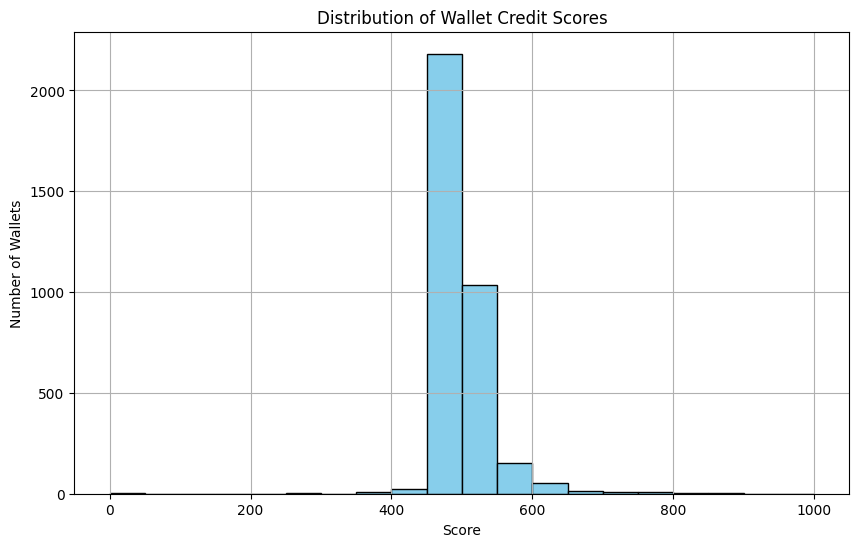


 Credit Score Buckets:
bucket
0-100          1
100-200        2
200-300        2
300-400        8
400-500     2255
500-600     1136
600-700       68
700-800       14
800-900        8
900-1000       2
Name: count, dtype: int64


In [13]:
# Step 5: Plot Score Distribution
plt.figure(figsize=(10, 6))
plt.hist(scored_df['credit_score'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Wallet Credit Scores")
plt.xlabel("Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.show()

# Step 6: Save Output
scored_df.to_csv("wallet_scores.csv", index=False)

# Step 7: Summary Buckets for analysis.md
scored_df['bucket'] = pd.cut(
    scored_df['credit_score'],
    bins=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    labels=["0-100", "100-200", "200-300", "300-400", "400-500",
            "500-600", "600-700", "700-800", "800-900", "900-1000"]
)

print("\n Credit Score Buckets:")
print(scored_df['bucket'].value_counts().sort_index())


In [14]:
print(features_df.describe())

           tx_count  num_deposits  num_borrows   num_repays  num_liquidations  \
count   3497.000000   3497.000000  3497.000000  3497.000000       3497.000000   
mean      28.595939     10.811553     4.885902     3.589648          0.070918   
std      250.732075     29.868997    15.133573    13.374770          0.692889   
min        1.000000      0.000000     0.000000     0.000000          0.000000   
25%        1.000000      1.000000     0.000000     0.000000          0.000000   
50%        3.000000      2.000000     0.000000     0.000000          0.000000   
75%       16.000000      6.000000     3.000000     2.000000          0.000000   
max    14265.000000    511.000000   200.000000   291.000000         26.000000   

          total_usd       avg_usd    usd_stddev  repay_borrow_ratio  \
count  3.497000e+03  3.497000e+03  2.442000e+03         3497.000000   
mean   3.337471e+23  6.056385e+21  1.115118e+22            0.357850   
std    5.079090e+24  8.274197e+22  1.085026e+23          

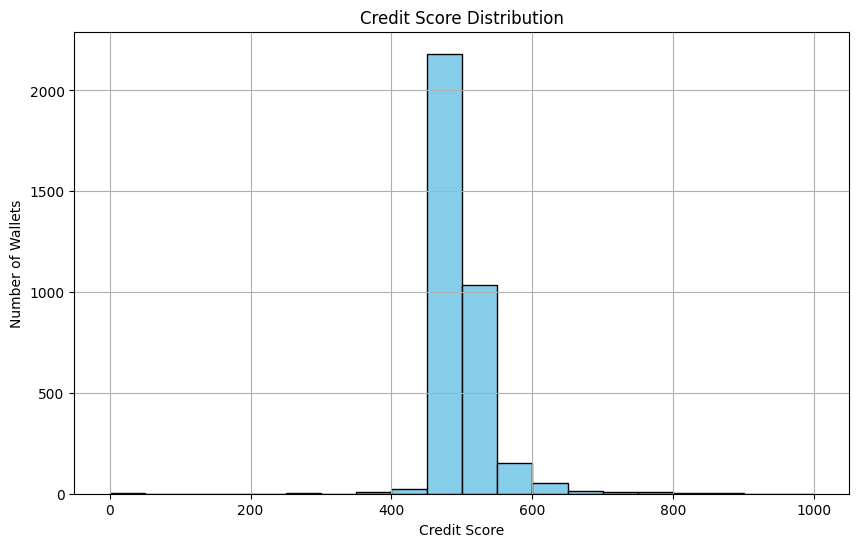

 Credit Score Buckets:
bucket
(0, 100]          1
(100, 200]        2
(200, 300]        2
(300, 400]        8
(400, 500]     2255
(500, 600]     1136
(600, 700]       68
(700, 800]       14
(800, 900]        8
(900, 1000]       2
Name: count, dtype: int64

-------- Lowest Scoring Wallets ----------------------------------------------------
                                  wallet_address  credit_score  num_deposits  \
2473  0x04426a58fdd02eb166b7c1a84ef390c4987ae1e0             0            17   
1574  0x02a16f8df2b11b3a0c9f47cc5d705830792e3e6f            10           111   
1730  0x02eb2ee0867dc3dfaa3862d0cc86984b6aada907           145            12   

      repay_borrow_ratio     total_usd  activity_duration_days  
2473            0.290323  2.165380e+22                6.464201  
1574            0.666667  8.195273e+21               51.467558  
1730            0.222222  9.335780e+21               30.167025  

-------- Median Scoring Wallets --------------------------------------------

In [15]:
from evaluate import plot_score_distribution, print_bucket_summary, show_wallet_examples

# `scored_df` is your credit score output
# `features_df` is your full engineered feature set

plot_score_distribution(scored_df)
print_bucket_summary(scored_df)
show_wallet_examples(scored_df, features_df)
